In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv as csv
import networkx as nx
import pandas as pd
from tqdm import tqdm

import csv

import os

import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import left_right_task as lrt, network_model, plot_style, util

In [2]:
# core parameters
rE_target = 10
rI_target = 5
Wji, pset, _, _, _, _ = util.load_fiducial_network(True)
max_duration = 6
dt = 1e-5

In [ ]:
# get all states
numPairs = Wji.shape[1]
states = network_model.get_all_states(Wji, pset, numPairs, rE_target, rI_target, duration = max_duration, dt=dt)
_, unique_idxs = np.unique(np.round(states, 0), axis=0, return_index=True)  # remove duplicates
states = [np.array(state) for state in states[unique_idxs]]  # convert to list

In [13]:
states_2 = network_model.get_all_states(Wji, pset, numPairs, rE_target, rI_target, duration = 3, dt=dt)
_, unique_idxs = np.unique(np.round(states_2, 0), axis=0, return_index=True)  # remove duplicates
states_2 = [np.array(state) for state in states_2[unique_idxs]]  # convert to list

In [5]:
stim_amplitude, stim_duration = 15, 0.05
equil_duration = 2

In [ ]:
# edge simulation setup
duration = 2*equil_duration + stim_duration
IappE = np.zeros((numPairs, int(duration/dt)))
IappE[::, int(equil_duration/dt):int((equil_duration + stim_duration)/dt)] = stim_amplitude  # apply stimulus to all pairs
IappI = np.copy(IappE)  # same for inhibitory units

# construct graph
G = nx.DiGraph()
unstable_states = False
for i, state in enumerate(states):
    G.add_node(i+1) # won't add repeated states

    rates = network_model.simulateISN(Wji, numPairs, state, pset,
                        IappE, IappI,
                        dt=dt, duration=duration)
    final_state = rates[:, :, -1]
    
    # no self loops (instead indicated by out-degree zero)
    if np.allclose(final_state, state, rtol=0, atol=0.5):
        continue
    
    # identify final_state
    for match_idx, match_state in enumerate(states):
        found = np.allclose(final_state, match_state, rtol=0, atol=0.5)
        if found:
            G.add_edge(i+1, match_idx+1) # adds nodes if necessary
            break
    if not found:
        # check stability
        stable = np.allclose(rates[:, :, int((duration-1)/dt):-1], rates[:, :, -1][..., np.newaxis], rtol=0, atol=0.1) and np.all(final_state < 100)
        if stable:
            G.add_edge(i+1, len(states) + 1)
            states.append(final_state)  # add new state if not found in the existing states
        else:
            unstable_states = True
            G.add_edge(i+1, -1) # always use -1 for unstable states (will always end up as a sink)
            # don't add to the states list -- don't want to simulate unstable states


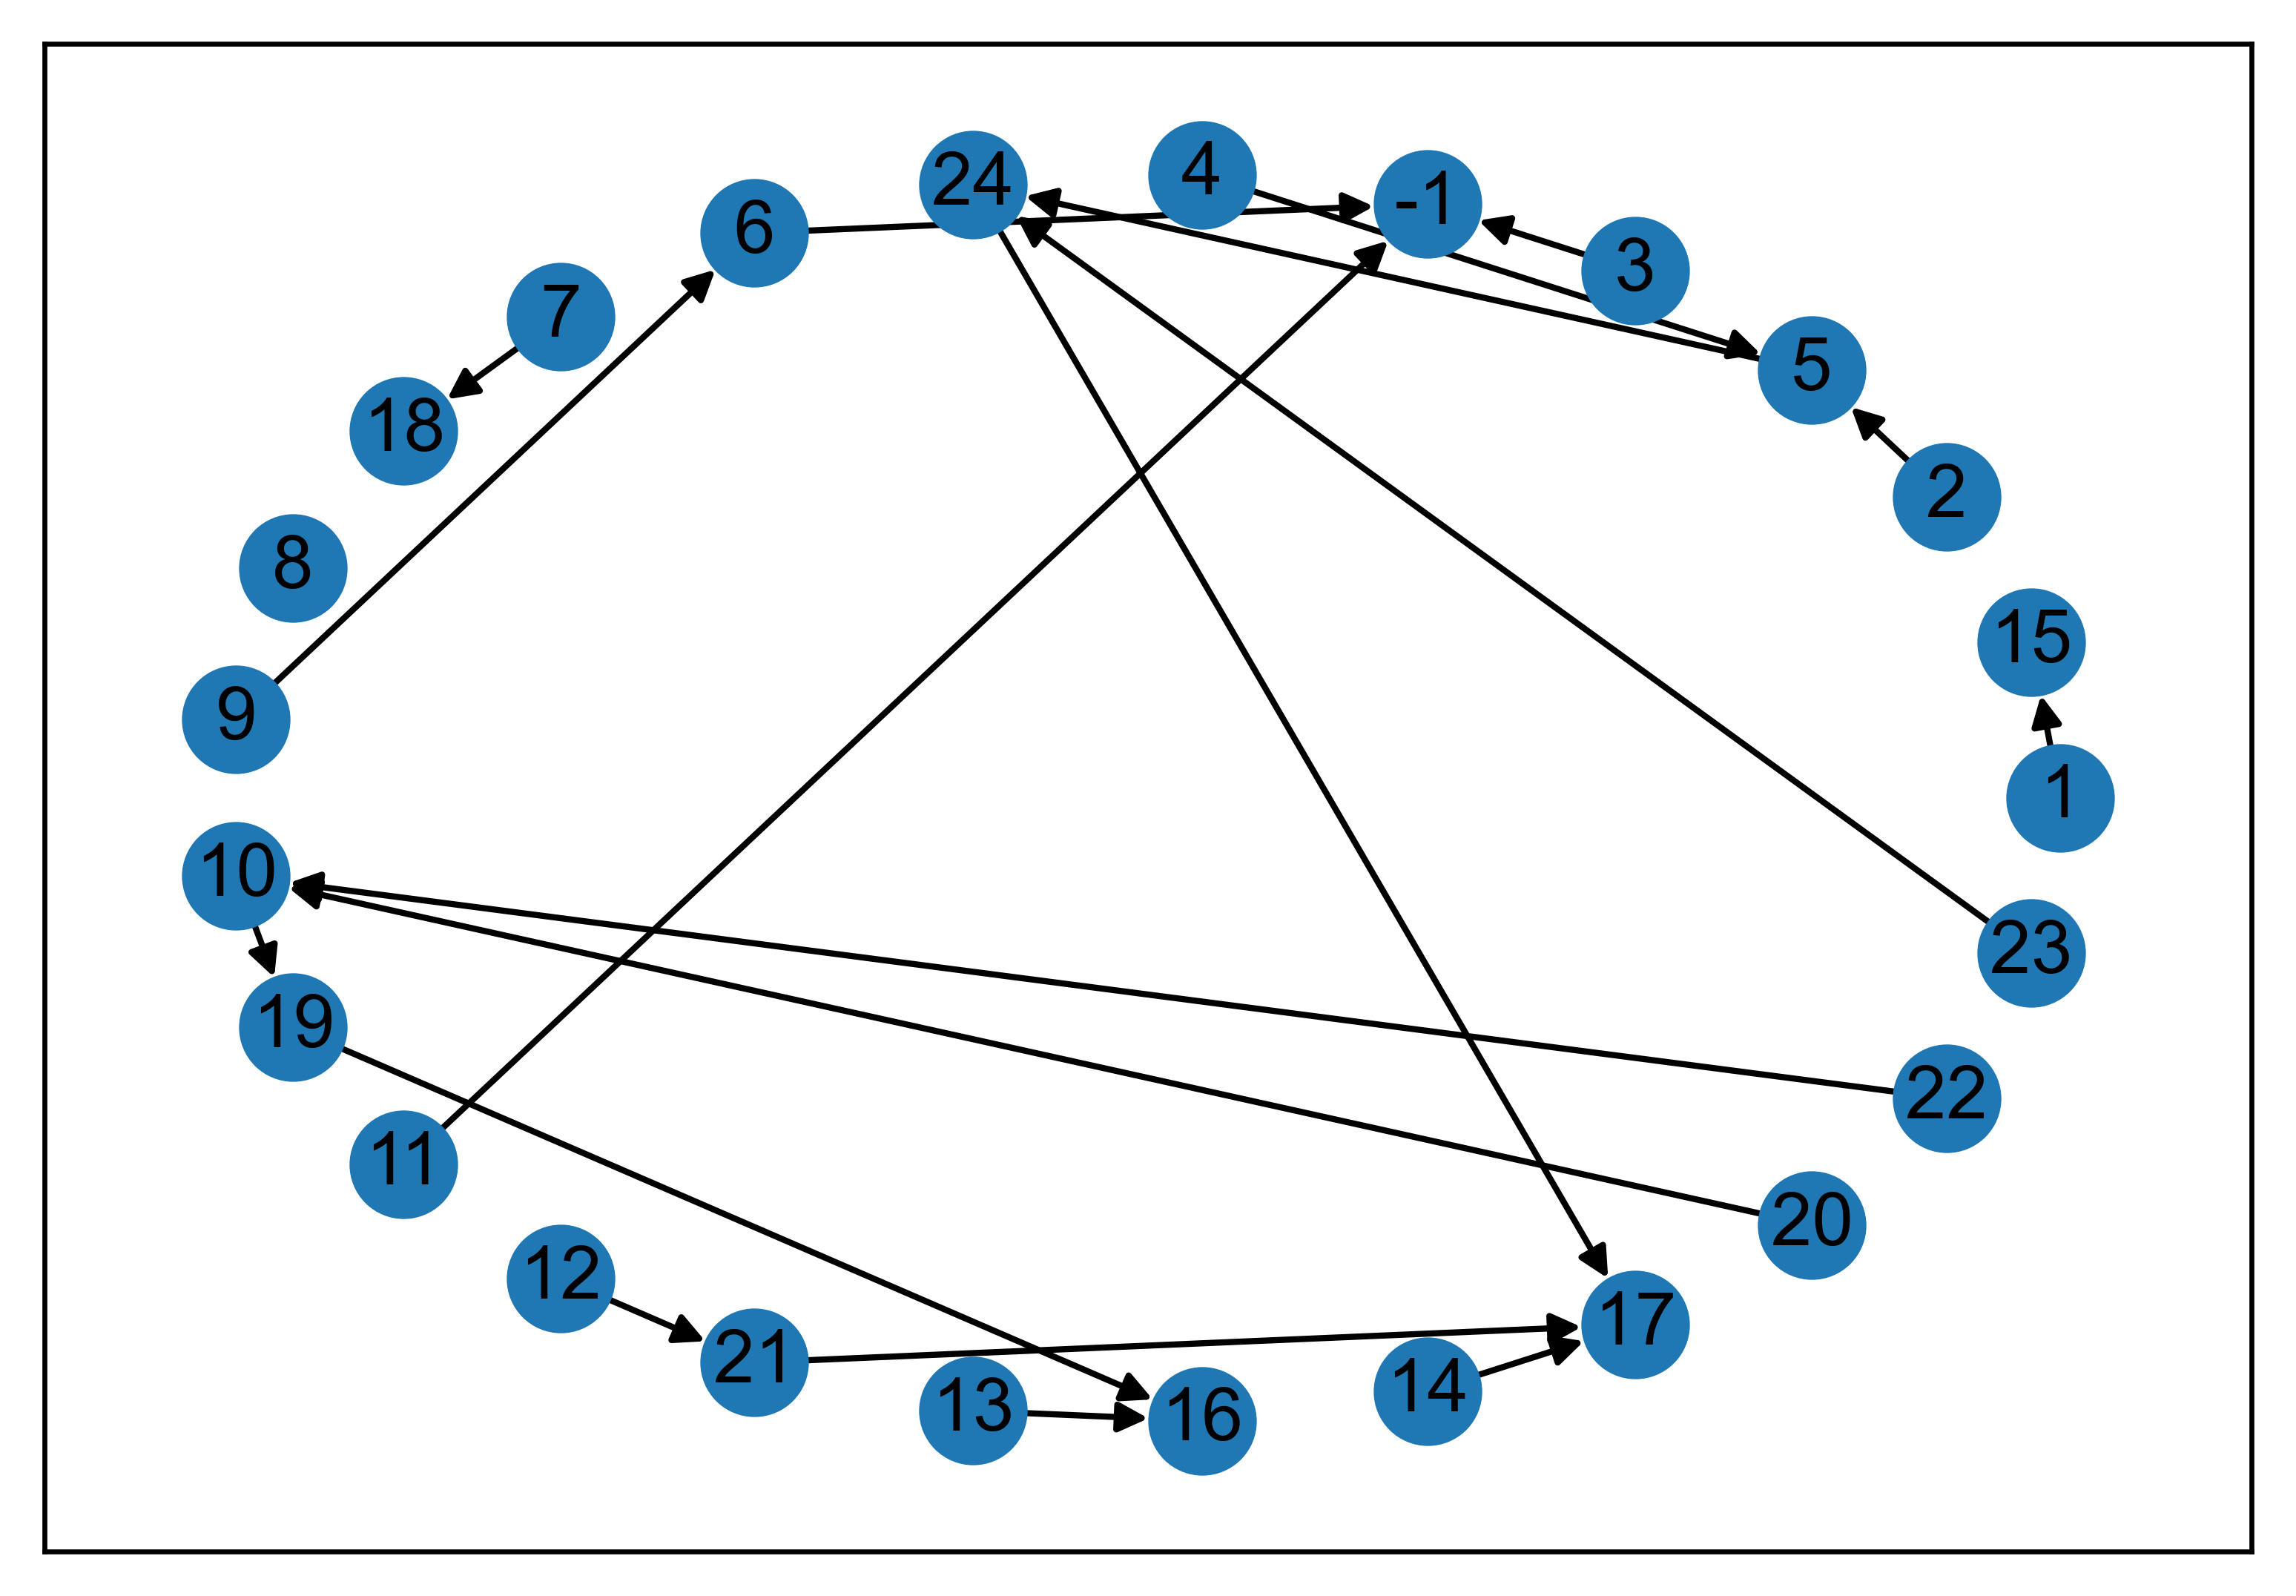

In [11]:
pos = nx.circular_layout(G)  # positions for all nodes
nx.draw_networkx(G, pos=pos, with_labels=True)

In [8]:
network_model.get_longest_path(G)

{2, 4, 5, 10, 16, 17, 19, 20, 22, 24}

In [9]:
network_model.longest_path(G)

3